# Instacart Reorders

<br/><br/>

<center> 
<img src="https://logos-download.com/wp-content/uploads/2016/10/Instacart_logo.png" width="600" height="200" />
</center>

<br/><br/>


## Package Import

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree

import xgboost as xgb
import imblearn.over_sampling
from collections import OrderedDict

# Notebook display settings
sns.set()
color = sns.color_palette()
%matplotlib inline
jtplot.style(theme='grade3') # Make graphs have white background
pd.options.mode.chained_assignment = None  # default='warn'

# Data Tables:
#    aisles
#    departments
#    order_products_prior
#    order_products_train
#    orders
#    products

## Data Import

Created a 50,000 order subset of the data (2,000,000 orders requires cloud computing for full processing)

In [4]:
# Unzip Instacart data subset ~50,000 orders
# Only run once to create unzipped file 

!unzip instacart_data_subset.zip

Archive:  instacart_data_subset.zip
   creating: instacart_data_subset/
  inflating: instacart_data_subset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/instacart_data_subset/
  inflating: __MACOSX/instacart_data_subset/._.DS_Store  
  inflating: instacart_data_subset/aisles.csv  
  inflating: __MACOSX/instacart_data_subset/._aisles.csv  
  inflating: instacart_data_subset/departments.csv  
  inflating: __MACOSX/instacart_data_subset/._departments.csv  
  inflating: instacart_data_subset/instacart_df_X_features.csv  
  inflating: instacart_data_subset/order_products__prior_subset.csv  
  inflating: instacart_data_subset/order_products__train_subset.csv  
  inflating: instacart_data_subset/orders_subset.csv  
  inflating: instacart_data_subset/products.csv  
  inflating: __MACOSX/instacart_data_subset/._products.csv  


In [5]:
# Define path of unzipped file
path = 'instacart_data_subset/'

### Setting up Dataframes

In [6]:
# Orders dataframe
orders_df = pd.read_csv(path + 'orders_subset.csv')
orders_df.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0


In [7]:
# Order Products Prior dataframe
order_products_prior_df = pd.read_csv(path + 'order_products__prior_subset.csv')
order_products_prior_df.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1


In [9]:
# Order Products Train dataframe
order_products_train_df = pd.read_csv(path + 'order_products__train_subset.csv')
order_products_train_df.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1


In [10]:
# Aisles dataframe
aisles_df = pd.read_csv(path + 'aisles.csv')
aisles_df.head(3)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


In [11]:
# Departments dataframe
departments_df = pd.read_csv(path + 'departments.csv')
departments_df.head(3)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


In [12]:
# Products dataframe
products_df = pd.read_csv(path + 'products.csv')
products_df.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


### Orders Merged with Products Prior and Products Train

In [13]:
# Adding Orders dataframe info to both products train and prior
order_products_train_df = order_products_train_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
order_products_prior_df = order_products_prior_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
order_products_train_df.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1077,13176,1,1,173934,11,6,9,10.0
1,1077,39922,2,1,173934,11,6,9,10.0
2,1077,5258,3,1,173934,11,6,9,10.0


In [14]:
# Adding Products dataframe info to both products train and prior
order_products_train_df = order_products_train_df.merge(products_df.drop('product_name', axis=1), on='product_id')
order_products_prior_df = order_products_prior_df.merge(products_df.drop('product_name', axis=1), on='product_id')
order_products_train_df.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,1077,13176,1,1,173934,11,6,9,10.0,24,4
1,1342,13176,1,1,156818,32,3,8,30.0,24,4
2,6286,13176,1,1,185494,14,3,9,9.0,24,4


In [15]:
order_products_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53704 entries, 0 to 53703
Data columns (total 11 columns):
order_id                  53704 non-null int64
product_id                53704 non-null int64
add_to_cart_order         53704 non-null int64
reordered                 53704 non-null int64
user_id                   53704 non-null int64
order_number              53704 non-null int64
order_dow                 53704 non-null int64
order_hour_of_day         53704 non-null int64
days_since_prior_order    53704 non-null float64
aisle_id                  53704 non-null int64
department_id             53704 non-null int64
dtypes: float64(1), int64(10)
memory usage: 4.9 MB


## Baseline Data Visualization

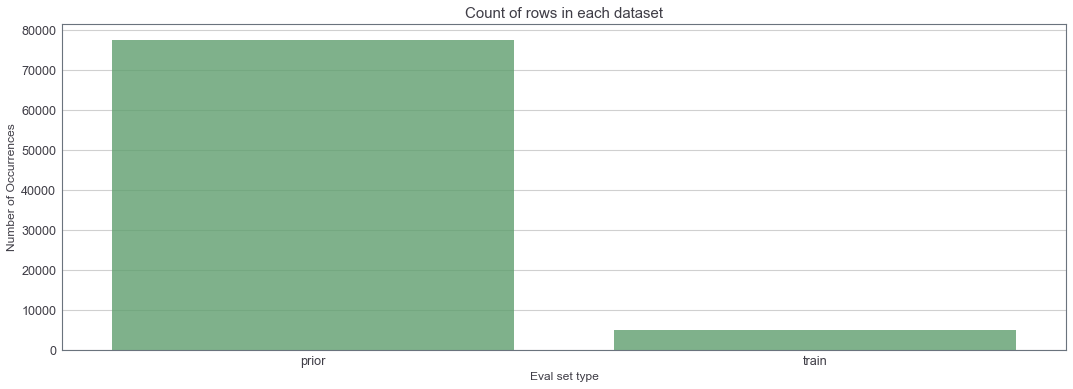

In [16]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(18,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.show()

In [17]:
# Get unique count of number of customers
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    5000
train    5000
Name: user_id, dtype: int64

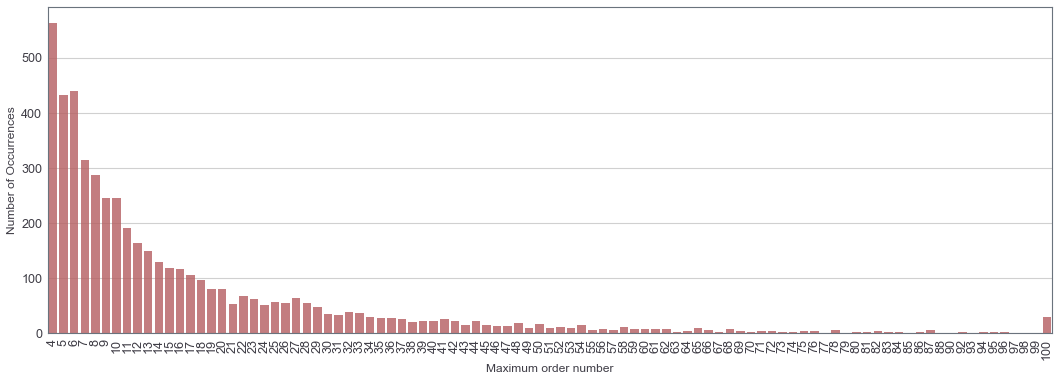

In [18]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(18,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

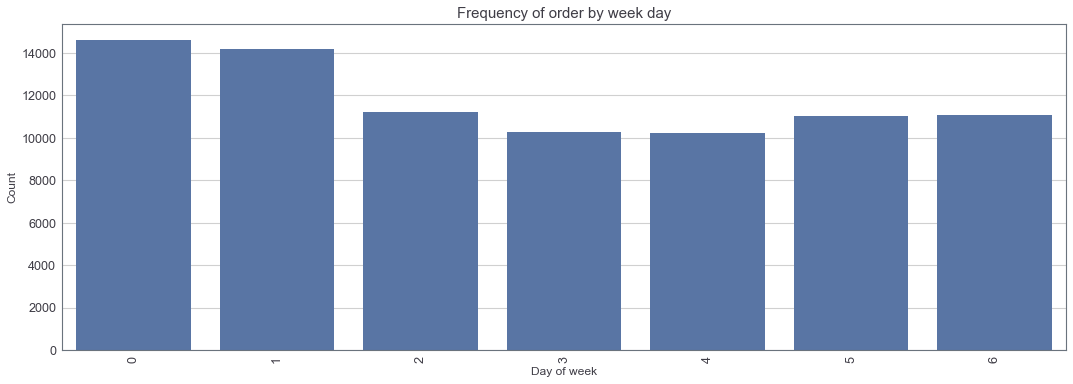

In [19]:
plt.figure(figsize=(18,6))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

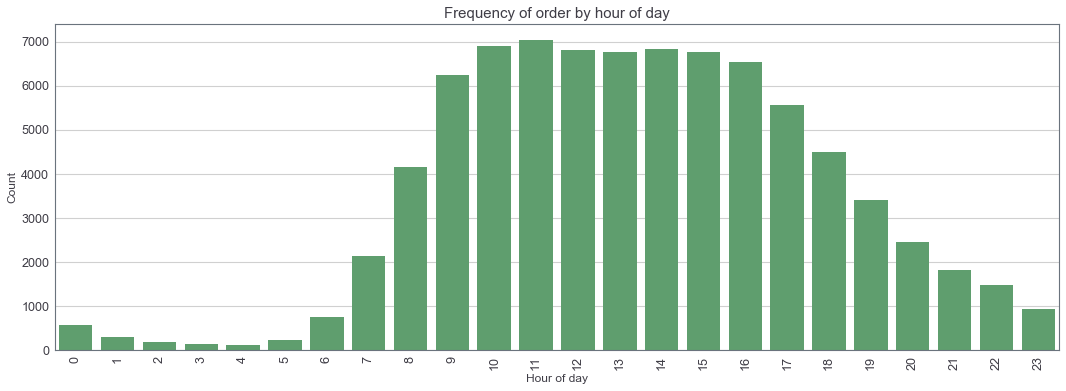

In [20]:
plt.figure(figsize=(18,6))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

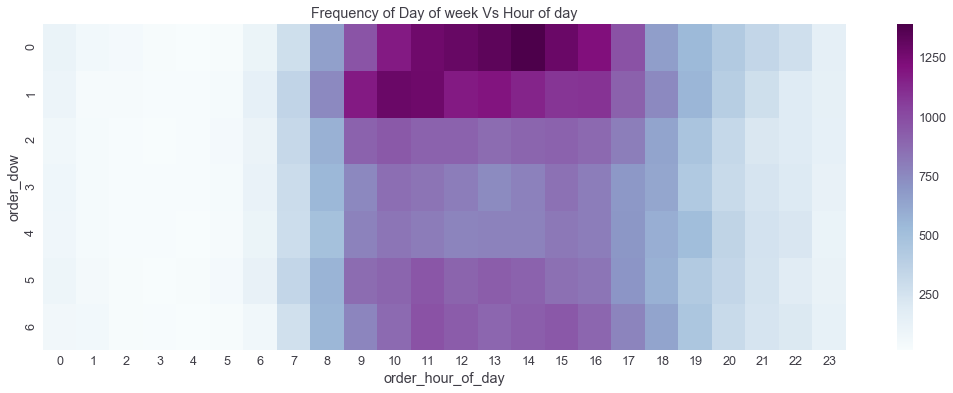

In [21]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='order_number')

plt.figure(figsize=(18,6))
sns.heatmap(grouped_df,cmap="BuPu")
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

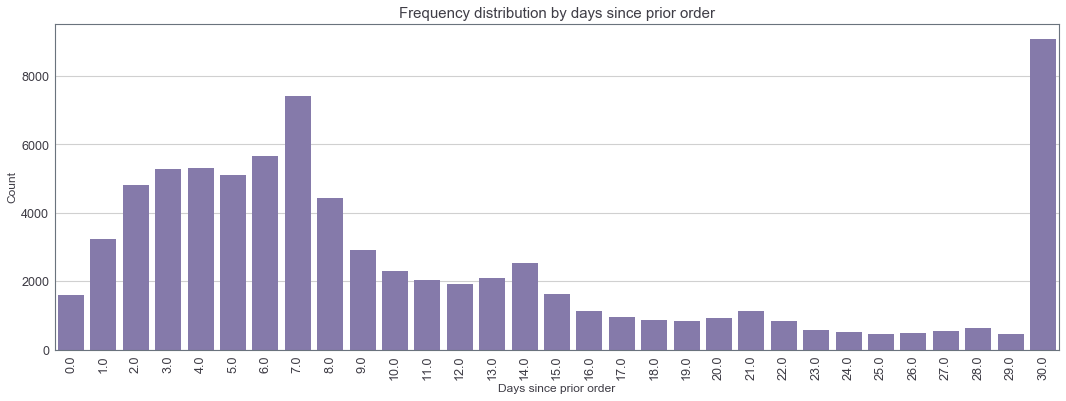

In [22]:
plt.figure(figsize=(18,6))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

# Reorders occur every most frequently once every 7 days or 30 days
# Also peaks at 14, 21, and 28 days

In [23]:
# percentage of re-orders in prior set 
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.584587441619097

In [24]:
# percentage of re-orders in train set 
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.6021711604349769

In [25]:
# Looking at orders with at least 1 reordered item in prior
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]
# 12% of orders did not have a single reordered item

1    0.881145
0    0.118855
Name: reordered, dtype: float64

In [26]:
# Looking at orders with at least 1 reordered item in train
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]
# 7% of orders did not have a single reordered item

1    0.941
0    0.059
Name: reordered, dtype: float64

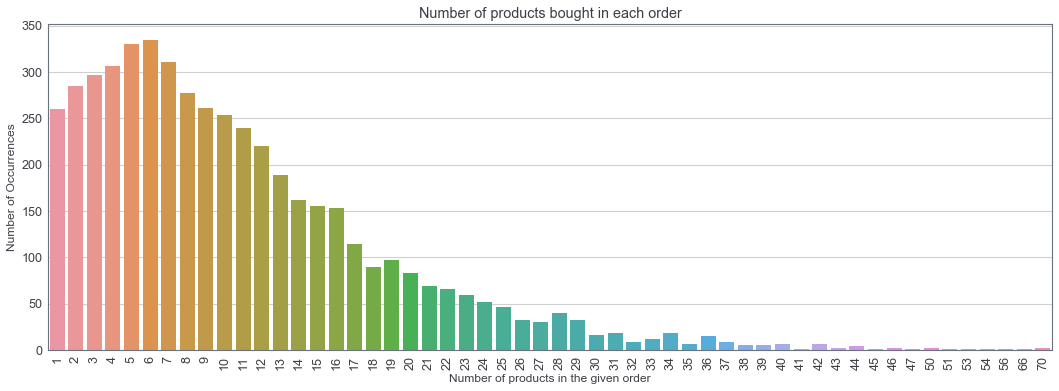

In [27]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(18,6))
sns.barplot(cnt_srs.index, cnt_srs.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.title('Number of products bought in each order')
plt.xticks(rotation='vertical')
plt.show()

## Feature Engineering

### Breakdown of Feature Categories

<br/><br/>
**Product Features**: general information about product purchase patterns across ALL users. The category of the product, its general popularity, how high priority the item tends to be, etc.
* **product_total_orders**: how many times has a given product_id been ordered before across all orders and all customers
* **product_avg_add_to_cart_order**: average order in which the product is being added to the cart across all orders and all customers
* **product_aisle_id**: aisle_id of product
* **product_department_id**: department_id of product
* **product_avg_order_dow**: average day of the week (rounded) the product was ordered on
* **product_avg_order_hour_of_day**: average hour of the day (rounded) the product was ordered during
* **product_total_users**: total # of unique users that have ordered the product


<br/><br/>
**User Features**: information about specific user behavior. How many items do they tend to order, how long has it been since they've last ordered, what time of day do they usually order, etc. 
* **user_total_orders**: count of total prior orders by user id
* **user_avg_cartsize**: average number of products across all carts by user id
* **user_total_products**: count of unique product ids ordered across all orders by user id
* **user_avg_days_since_prior_order**: average of days since prior order across all orders by user id


<br/><br/>
**User-Product** features: information about product-specific user behavior. How often have they ordered this product, how high-priority does it tend to be for them, how long has it been since they've ordered this product, etc.
* **user_product_avg_add_to_cart_order**: average order in which each product id is added to a cart across all orders by user id
* **user_product_avg_order_dow**: average day of the week product is ordered on user-product level
* **user_product_avg_order_hour_of_day**: average hour of the day the product is ordered on user-product level
* **max_order_number_per_product**: max order number a product showed up in based on user_id
* **user_product_order_freq**: how often the user bought the product out of the user's total orders
* **user_product_orders_ago_ordered**: how many orders ago the user last ordered the product
* **user_product_times_bought_in_last_five_orders**: how many times the user bought the product in their last 5 orders
* **user_product_times_bought_in_last_ten_orders**: how many times the user bought the product in their last 10 orders
* **weighted_reorder_sum**: a weighted sum of product reorders by user id (more weight the more recent the reorder)
* **weighted_reorder_squared_sum**: a weighted sum of product reorders by user id (even more weight the more recent the reorder)
* **consecutive_reorder_count**: counts how many times the product was consecutively reordered
* **consecutive_reorder_percent**: percent of how many orders were consecutive as a percent of total orders for a product
* **days_since_last_order**: count of days since the last time the product was orderd by the user

<br/><br/>


In [28]:
# Creating initial X_df to store product_id and user_id
user_product_df = (order_products_prior_df.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

train_ids = order_products_train_df['user_id'].unique() 
X_df = user_product_df[user_product_df['user_id'].isin(train_ids)]
X_df = X_df.drop(['user_product_total_orders'],axis=1)
X_df.head()

,product_id,user_id
0,1,21285
1,1,47549
2,1,54136
3,1,54240
4,1,95730


In [29]:
# Setting up latest_cart and in_cart to create target variable in X_df
train_carts = (order_products_train_df.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

X_df = X_df.merge(train_carts, on='user_id')
X_df['in_cart'] = (X_df.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))
X_df.head()

,product_id,user_id,latest_cart,in_cart
0,1,21285,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0
1,3298,21285,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0
2,4920,21285,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0
3,6066,21285,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0
4,6184,21285,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0


In [30]:
# Check proportion of train products that were reordered
X_df.in_cart.value_counts(normalize=True)

0    0.901945
1    0.098055
Name: in_cart, dtype: float64

### Product Features

In [31]:
# First category of features are product_id specific features

prod_features = ['product_total_orders','product_avg_add_to_cart_order','product_aisle_id','product_department_id',
                 'product_avg_order_dow','product_avg_order_hour_of_day','product_total_users']

# Using max on aisle and dept id just as a trick to extract from groupby

prod_features_df = (order_products_prior_df.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean'),
                                                    ('aisle_id','max'),
                                                    ('department_id','max'),
                                                    ('order_dow','mean'),
                                                    ('order_hour_of_day','mean'),
                                                    ('user_id','nunique')])))
prod_features_df.columns = ['product_id'] + prod_features

# Round back to get categorical days and binned hours
prod_features_df.product_avg_order_dow = prod_features_df.product_avg_order_dow.round()
prod_features_df.product_avg_order_hour_of_day = prod_features_df.product_avg_order_hour_of_day.round()

prod_features_df.head(3)

,product_id,product_total_orders,product_avg_add_to_cart_order,product_aisle_id,product_department_id,product_avg_order_dow,product_avg_order_hour_of_day,product_total_users
0,1,26,4.576923,61,19,3.0,13.0,12
1,2,1,3.000000,104,13,4.0,12.0,1
2,3,1,4.000000,94,7,4.0,17.0,1


In [32]:
# Merge in product features into X_df on product_id
X_df = X_df.merge(prod_features_df, on='product_id')
X_df = X_df.dropna()
X_df.head(1)

,product_id,user_id,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_aisle_id,product_department_id,product_avg_order_dow,product_avg_order_hour_of_day,product_total_users
0,1,21285,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0,26,4.576923,61,19,3.0,13.0,12


In [33]:
# There is a risk to overfitting user specific behavior, which would make having the same user in both train and
# test bad (since you'd have an overfit model testing on the same user in the test set). So split on users, not
# on user-product

# Baseline with Product Features

# Sample 20% of users
np.random.seed(45)
total_users = X_df['user_id'].unique() 
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .20), replace=False)

# Split into train/test
X_train_df, X_test_df = X_df[~X_df['user_id'].isin(test_users)], X_df[X_df['user_id'].isin(test_users)] 

# Split into features/target
y_train, y_test = X_train_df['in_cart'], X_test_df['in_cart']
X_train, X_test = X_train_df.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
                  X_test_df.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \

# Fit simple baseline model
lr = LogisticRegression()
lr.fit(X_train, y_train)
metrics.f1_score(lr.predict(X_test), y_test)

/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.0

### User Features

In [34]:
# Second category of features are user specific features

user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

user_features_df = (order_products_prior_df.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))

user_features_df.columns = ['user_id'] + user_features

user_features_df.head(3)

,user_id,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,50,67,6.761194,89,5.691275
1,52,27,6.259259,51,9.134969
2,65,14,9.428571,80,13.594828


In [35]:
# Merge user features into X_df on user_id
X_df = X_df.merge(user_features_df, on='user_id')
X_df = X_df.dropna()
X_df.head(1)

,product_id,user_id,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_aisle_id,product_department_id,product_avg_order_dow,product_avg_order_hour_of_day,product_total_users,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,1,21285,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0,26,4.576923,61,19,3.0,13.0,12,48,6.604167,46,8.044872


In [36]:
# Baseline with Product & User Features (using same user_id 20/80 split defined in Product Features category)

# Split into train/test
X_train_df, X_test_df = X_df[~X_df['user_id'].isin(test_users)], X_df[X_df['user_id'].isin(test_users)] 

# Split into features/target
y_train, y_test = X_train_df['in_cart'], X_test_df['in_cart']
X_train, X_test = X_train_df.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
                  X_test_df.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \

# Fit simple baseline model
lr = LogisticRegression()
lr.fit(X_train, y_train)
metrics.f1_score(lr.predict(X_test), y_test)

0.014392991239048813

### User-Product Features

#### User-Product Features Setup

In [37]:
# Creating a cart for each prior order (to be used to create User-Product features)
prior_carts = (order_products_prior_df.groupby(['user_id','order_id'],as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'order_id_cart'}))
prior_carts.head(2)

,user_id,order_id,order_id_cart
0,50,103726,"{39877, 6182, 31720, 22825, 34409, 42701, 2190..."
1,50,131991,"{7014, 6182, 47209, 47018, 19678}"


In [38]:
# Adding cart for each order id to prior_products to set up for reorder comparison features
order_products_prior_df = order_products_prior_df.merge(prior_carts.drop('user_id', axis=1), on='order_id')
order_products_prior_df.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,order_id_cart
0,12,30597,1,1,152610,22,6,8,10.0,53,16,"{38050, 30597, 11175, 38888, 34335, 3164, 2339..."
1,12,15221,2,1,152610,22,6,8,10.0,84,16,"{38050, 30597, 11175, 38888, 34335, 3164, 2339..."


In [39]:
# Creating a set that contains past order numbers in which the product_id was ordered in
order_number_per_product = (order_products_prior_df.groupby(['product_id','user_id'],as_index=False)
                                      .agg({'order_number':(lambda x: set(x))})
                                      .rename(columns={'order_number':'order_number_per_product'}))
order_number_per_product.head(2)

,product_id,user_id,order_number_per_product
0,1,21285,{2}
1,1,47549,"{8, 17, 11, 21}"


In [40]:
# Adding order_number set for each product_id & user_id to prior_products to set up for reorder comparison features
order_products_prior_df = order_products_prior_df.merge(order_number_per_product, on=('product_id','user_id'))
order_products_prior_df.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,order_id_cart,order_number_per_product
0,12,30597,1,1,152610,22,6,8,10.0,53,16,"{38050, 30597, 11175, 38888, 34335, 3164, 2339...","{2, 4, 5, 7, 22}"
1,138033,30597,3,0,152610,2,4,13,13.0,53,16,"{44162, 46979, 30597, 28553, 49683, 27796, 348...","{2, 4, 5, 7, 22}"


In [41]:
# Add max order column to order_products_prior_df
# (max_order_number_per_product will also be used as a feature in X_df, as shown in User-Product Features section)
order_products_prior_df["max_order_number_per_product"] = order_products_prior_df["order_number_per_product"].map(lambda x: max(x))
order_products_prior_df.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,order_id_cart,order_number_per_product,max_order_number_per_product
0,12,30597,1,1,152610,22,6,8,10.0,53,16,"{38050, 30597, 11175, 38888, 34335, 3164, 2339...","{2, 4, 5, 7, 22}",22
1,138033,30597,3,0,152610,2,4,13,13.0,53,16,"{44162, 46979, 30597, 28553, 49683, 27796, 348...","{2, 4, 5, 7, 22}",22


In [42]:
# Creating user_total_orders_minus_five column for user_product_times_bought_in_last_five_orders feature's use
user_total_orders = user_features_df.drop(['user_avg_cartsize','user_total_products','user_avg_days_since_prior_order'],axis=1)
user_total_orders['user_total_orders_minus_five'] = user_total_orders['user_total_orders'] - 5
user_total_orders['user_total_orders_minus_ten'] = user_total_orders['user_total_orders'] - 10
order_products_prior_df = order_products_prior_df.merge(user_total_orders, on='user_id')
order_products_prior_df.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,order_id_cart,order_number_per_product,max_order_number_per_product,user_total_orders,user_total_orders_minus_five,user_total_orders_minus_ten
0,12,30597,1,1,152610,22,6,8,10.0,53,16,"{38050, 30597, 11175, 38888, 34335, 3164, 2339...","{2, 4, 5, 7, 22}",22,26,21,16
1,138033,30597,3,0,152610,2,4,13,13.0,53,16,"{44162, 46979, 30597, 28553, 49683, 27796, 348...","{2, 4, 5, 7, 22}",22,26,21,16


In [43]:
# Add last five orders feature using function
def last_five_orders(user_total_orders_minus_five,order_set):
    times_bought_in_last_five_order = 0
    for order_num in order_set:
        if order_num >= user_total_orders_minus_five:
            times_bought_in_last_five_order += 1
    return times_bought_in_last_five_order

# Add last ten orders feature using function
def last_ten_orders(user_total_orders_minus_ten,order_set):
    times_bought_in_last_ten_order = 0
    for order_num in order_set:
        if order_num >= user_total_orders_minus_ten:
            times_bought_in_last_ten_order += 1
    return times_bought_in_last_ten_order

order_products_prior_df["user_product_times_bought_in_last_five_orders"] = order_products_prior_df.apply(lambda row: last_five_orders(row.user_total_orders_minus_five,row.order_number_per_product),axis=1)
order_products_prior_df["user_product_times_bought_in_last_ten_orders"] = order_products_prior_df.apply(lambda row: last_ten_orders(row.user_total_orders_minus_ten,row.order_number_per_product),axis=1)
order_products_prior_df.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,order_id_cart,order_number_per_product,max_order_number_per_product,user_total_orders,user_total_orders_minus_five,user_total_orders_minus_ten,user_product_times_bought_in_last_five_orders,user_product_times_bought_in_last_ten_orders
0,12,30597,1,1,152610,22,6,8,10.0,53,16,"{38050, 30597, 11175, 38888, 34335, 3164, 2339...","{2, 4, 5, 7, 22}",22,26,21,16,1,1
1,138033,30597,3,0,152610,2,4,13,13.0,53,16,"{44162, 46979, 30597, 28553, 49683, 27796, 348...","{2, 4, 5, 7, 22}",22,26,21,16,1,1


In [44]:
# Weighted reorder feature (Sum(order_number/user_total_orders))
def weighted_reorder_sum(order_set,user_total_orders):
    weighted_reorder_sum = 0
    for order_num in order_set:
        x = order_num / user_total_orders
        weighted_reorder_sum += x
    return weighted_reorder_sum

# Weighted reorder feature (Sum(squared(order_number/user_total_orders)))
def weighted_reorder_squared_sum(order_set,user_total_orders):
    weighted_reorder_squared_sum = 0
    for order_num in order_set:
        x = (order_num / user_total_orders)**2
        weighted_reorder_squared_sum += x
    return weighted_reorder_squared_sum

order_products_prior_df["weighted_reorder_sum"] = order_products_prior_df.apply(lambda row: weighted_reorder_sum(row.order_number_per_product,row.user_total_orders),axis=1)
order_products_prior_df["weighted_reorder_squared_sum"] = order_products_prior_df.apply(lambda row: weighted_reorder_squared_sum(row.order_number_per_product,row.user_total_orders),axis=1)
order_products_prior_df.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,...,order_id_cart,order_number_per_product,max_order_number_per_product,user_total_orders,user_total_orders_minus_five,user_total_orders_minus_ten,user_product_times_bought_in_last_five_orders,user_product_times_bought_in_last_ten_orders,weighted_reorder_sum,weighted_reorder_squared_sum
0,12,30597,1,1,152610,22,6,8,10.0,53,...,"{38050, 30597, 11175, 38888, 34335, 3164, 2339...","{2, 4, 5, 7, 22}",22,26,21,16,1,1,1.538462,0.85503
1,138033,30597,3,0,152610,2,4,13,13.0,53,...,"{44162, 46979, 30597, 28553, 49683, 27796, 348...","{2, 4, 5, 7, 22}",22,26,21,16,1,1,1.538462,0.85503


In [45]:
# Consecutive reorders count feature
def consecutive_reorder_count(order_set):
    consecutive_reorder_count = 0
    order_set = sorted(order_set)
    order_set = list(order_set)
    if len(order_set) != 1:
        for idx,order_num in enumerate(order_set[:-1]):
            x1 = order_num
            x2 = order_set[idx+1]
            if x1+1 == x2:
                consecutive_reorder_count += 1
        return consecutive_reorder_count
    else:
        return 0
    
# Consecutive reorders as a percent of total orders feature
def consecutive_reorder_percent(order_set):
    consecutive_reorder_count = 0
    order_set = sorted(order_set)
    order_set = list(order_set)
    if len(order_set) != 1:
        for idx,order_num in enumerate(order_set[:-1]):
            x1 = order_num
            x2 = order_set[idx+1]
            if x1+1 == x2:
                consecutive_reorder_count += 1
        return consecutive_reorder_count / len(order_set)
    else:
        return 0

order_products_prior_df["consecutive_reorder_count"] = order_products_prior_df.apply(lambda row: consecutive_reorder_count(row.order_number_per_product),axis=1)
order_products_prior_df["consecutive_reorder_percent"] = order_products_prior_df.apply(lambda row: consecutive_reorder_percent(row.order_number_per_product),axis=1)
order_products_prior_df.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,...,max_order_number_per_product,user_total_orders,user_total_orders_minus_five,user_total_orders_minus_ten,user_product_times_bought_in_last_five_orders,user_product_times_bought_in_last_ten_orders,weighted_reorder_sum,weighted_reorder_squared_sum,consecutive_reorder_count,consecutive_reorder_percent
0,12,30597,1,1,152610,22,6,8,10.0,53,...,22,26,21,16,1,1,1.538462,0.85503,1,0.2
1,138033,30597,3,0,152610,2,4,13,13.0,53,...,22,26,21,16,1,1,1.538462,0.85503,1,0.2


In [46]:
# Creating tuple for each user_id which stores sorted days_since_prior_order values
user_order_df = order_products_prior_df.sort_values(['user_id','order_number'])

user_order_df = (user_order_df.groupby(['user_id','order_number'],as_index=False) 
                              .agg({'days_since_prior_order':'max'}))

user_days_since_prior_order = (user_order_df.groupby(['user_id'],as_index=False) 
                                            .agg({'days_since_prior_order':(lambda x: tuple(x))})
                                            .rename(columns={'days_since_prior_order':'days_since_prior_order_tuple'}))

order_products_prior_df = order_products_prior_df.merge(user_days_since_prior_order, on='user_id')
order_products_prior_df.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,...,user_total_orders,user_total_orders_minus_five,user_total_orders_minus_ten,user_product_times_bought_in_last_five_orders,user_product_times_bought_in_last_ten_orders,weighted_reorder_sum,weighted_reorder_squared_sum,consecutive_reorder_count,consecutive_reorder_percent,days_since_prior_order_tuple
0,12,30597,1,1,152610,22,6,8,10.0,53,...,26,21,16,1,1,1.538462,0.85503,1,0.2,"(nan, 13.0, 30.0, 8.0, 16.0, 4.0, 19.0, 10.0, ..."
1,138033,30597,3,0,152610,2,4,13,13.0,53,...,26,21,16,1,1,1.538462,0.85503,1,0.2,"(nan, 13.0, 30.0, 8.0, 16.0, 4.0, 19.0, 10.0, ..."


In [48]:
# Days since last order feature
def days_since_last_order(max_order_number_per_product,days_since_prior_order_tuple):
    days_since_prior_order_tuple = np.nan_to_num(days_since_prior_order_tuple)
    return sum(days_since_prior_order_tuple[max_order_number_per_product-1:])

# Max days between orders feature
def max_days_between_orders(order_number_per_product,days_since_prior_order_tuple,max_order_number_per_product):
    days_since_prior_order_tuple = np.nan_to_num(days_since_prior_order_tuple)
    order_number_per_product = list(order_number_per_product)
    if len(order_number_per_product) != 1:
        list_of_sums = []
        for idx,order_num in enumerate(order_number_per_product[:-1]):
            start_pos = order_num - 1
            length = order_number_per_product[idx+1] - order_num
            list_of_sums.append(sum(days_since_prior_order_tuple[start_pos:start_pos+length]))
        return max(list_of_sums)     
    else:
        return sum(days_since_prior_order_tuple[max_order_number_per_product-1:])
    
order_products_prior_df['days_since_last_order'] = order_products_prior_df.apply(lambda row: days_since_last_order(row.max_order_number_per_product,row.days_since_prior_order_tuple),axis=1)
order_products_prior_df['max_days_between_orders'] = order_products_prior_df.apply(lambda row: max_days_between_orders(row.order_number_per_product,row.days_since_prior_order_tuple,row.max_order_number_per_product),axis=1)
order_products_prior_df.head(2)

# DEBUG + Subtract the two features to create a third

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,...,user_total_orders_minus_ten,user_product_times_bought_in_last_five_orders,user_product_times_bought_in_last_ten_orders,weighted_reorder_sum,weighted_reorder_squared_sum,consecutive_reorder_count,consecutive_reorder_percent,days_since_prior_order_tuple,days_since_last_order,max_days_between_orders
0,12,30597,1,1,152610,22,6,8,10.0,53,...,16,1,1,1.538462,0.85503,1,0.2,"(nan, 13.0, 30.0, 8.0, 16.0, 4.0, 19.0, 10.0, ...",40.0,166.0
1,138033,30597,3,0,152610,2,4,13,13.0,53,...,16,1,1,1.538462,0.85503,1,0.2,"(nan, 13.0, 30.0, 8.0, 16.0, 4.0, 19.0, 10.0, ...",40.0,166.0


#### User-Product Features

In [49]:
# Third category of features are user-product specific features

user_prod_features = ['user_product_avg_add_to_cart_order','user_product_total_orders','user_product_avg_order_dow',
                      'user_product_avg_order_hour_of_day','max_order_number_per_product','user_product_times_bought_in_last_five_orders',
                      'user_product_times_bought_in_last_ten_orders','weighted_reorder_sum','weighted_reorder_squared_sum',
                      'consecutive_reorder_count','consecutive_reorder_percent','days_since_last_order','max_days_between_orders']

user_prod_features_df = (order_products_prior_df.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean'),
                                                      ('order_id','count'),
                                                      ('order_dow','mean'),
                                                      ('order_hour_of_day','mean'),
                                                      ('max_order_number_per_product','max'),
                                                      ('user_product_times_bought_in_last_five_orders','max'),
                                                      ('user_product_times_bought_in_last_ten_orders','max'),
                                                      ('weighted_reorder_sum','max'),
                                                      ('weighted_reorder_squared_sum','max'),
                                                      ('consecutive_reorder_count','max'),
                                                      ('consecutive_reorder_percent','max'),
                                                      ('days_since_last_order','min'),
                                                      ('max_days_between_orders','min')])))

user_prod_features_df.columns = ['product_id','user_id'] + user_prod_features 

# Round back to get categorical days and binned hours
user_prod_features_df.user_product_avg_order_dow = user_prod_features_df.user_product_avg_order_dow.round()
user_prod_features_df.user_product_avg_order_hour_of_day = user_prod_features_df.user_product_avg_order_hour_of_day.round()

user_prod_features_df.head(10)

,product_id,user_id,user_product_avg_add_to_cart_order,user_product_total_orders,user_product_avg_order_dow,user_product_avg_order_hour_of_day,max_order_number_per_product,user_product_times_bought_in_last_five_orders,user_product_times_bought_in_last_ten_orders,weighted_reorder_sum,weighted_reorder_squared_sum,consecutive_reorder_count,consecutive_reorder_percent,days_since_last_order,max_days_between_orders
0,1,21285,3.0,1,0.0,15.0,2,0,0,0.041667,0.001736,0,0.000,356.0,356.0
1,1,47549,4.0,4,4.0,18.0,21,1,2,2.192308,1.353550,0,0.000,110.0,100.0
2,1,54136,3.0,1,2.0,13.0,18,1,1,0.782609,0.612476,0,0.000,97.0,97.0
3,1,54240,2.0,1,2.0,16.0,1,1,1,0.200000,0.040000,0,0.000,120.0,120.0
4,1,95730,1.0,1,1.0,14.0,7,1,1,0.777778,0.604938,0,0.000,74.0,74.0
5,1,96682,4.0,8,3.0,12.0,23,1,1,2.888889,1.448560,3,0.375,64.0,148.0
6,1,109784,8.0,1,3.0,7.0,5,1,1,1.000000,1.000000,0,0.000,30.0,30.0
7,1,110040,2.5,2,1.0,16.0,28,0,0,0.414634,0.121951,0,0.000,259.0,0.0
8,1,118812,11.0,1,3.0,19.0,11,0,1,0.647059,0.418685,0,0.000,145.0,145.0
9,1,126451,3.5,2,4.0,8.0,7,2,2,1.857143,1.734694,1,0.500,22.0,30.0


In [50]:
# Merge user-product features into X_df based on user_id & product_id
X_df = X_df.merge(user_prod_features_df, on=['user_id','product_id'])

# Creating user_product_order_freq outide of user_prod_features cell because feature uses features from two categories
X_df['user_product_order_freq'] = X_df['user_product_total_orders'] / X_df['user_total_orders'] 
X_df['user_product_orders_ago_ordered'] = (X_df['user_total_orders'] + 1) - X_df['max_order_number_per_product']

X_df = X_df.dropna()
X_df.head(1)

,product_id,user_id,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,product_aisle_id,product_department_id,product_avg_order_dow,product_avg_order_hour_of_day,...,user_product_times_bought_in_last_five_orders,user_product_times_bought_in_last_ten_orders,weighted_reorder_sum,weighted_reorder_squared_sum,consecutive_reorder_count,consecutive_reorder_percent,days_since_last_order,max_days_between_orders,user_product_order_freq,user_product_orders_ago_ordered
0,1,21285,"{21573, 35561, 37710, 11759, 12341, 13176, 32478}",0,26,4.576923,61,19,3.0,13.0,...,0,0,0.041667,0.001736,0,0.0,356.0,356.0,0.020833,47


In [51]:
# Full feature and target set
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329806 entries, 0 to 329805
Data columns (total 30 columns):
product_id                                       329806 non-null int64
user_id                                          329806 non-null int64
latest_cart                                      329806 non-null object
in_cart                                          329806 non-null int64
product_total_orders                             329806 non-null int64
product_avg_add_to_cart_order                    329806 non-null float64
product_aisle_id                                 329806 non-null int64
product_department_id                            329806 non-null int64
product_avg_order_dow                            329806 non-null float64
product_avg_order_hour_of_day                    329806 non-null float64
product_total_users                              329806 non-null int64
user_total_orders                                329806 non-null int64
user_avg_cartsize             

In [52]:
# Baseline with Product, User, & User-Product Features  (using same user_id 20/80 split in Product Features category)

# Split into train/test
X_train_df, X_test_df = X_df[~X_df['user_id'].isin(test_users)], X_df[X_df['user_id'].isin(test_users)] 

# Split into features/target
y_train, y_test = X_train_df['in_cart'], X_test_df['in_cart']
X_train, X_test = X_train_df.drop(['product_id','user_id','latest_cart','in_cart',],axis=1), \
                  X_test_df.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \

# Fit simple baseline model
lr = LogisticRegression()
lr.fit(X_train, y_train)
metrics.f1_score(y_test, lr.predict(X_test))

0.2670993509735397

## Modeling

### Splitting up data

In [53]:
# Sample 20% of users for holdout (test)
np.random.seed(45)
total_users = X_df['user_id'].unique() 
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .20), replace=False)

# Split into train/test on 80/20 split of users
X_train_df, X_test_df = X_df[~X_df['user_id'].isin(test_users)], X_df[X_df['user_id'].isin(test_users)] 

# Split train into 5 folds for cross-validation
train_users = X_train_df['user_id'].unique()
np.random.shuffle(train_users)
train_users_5folds = np.split(train_users,5)

# Test sets for cross-validation
X_valid_df_fold1 = X_train_df[X_train_df['user_id'].isin(train_users_5folds[0])] 
X_valid_df_fold2 = X_train_df[X_train_df['user_id'].isin(train_users_5folds[1])] 
X_valid_df_fold3 = X_train_df[X_train_df['user_id'].isin(train_users_5folds[2])] 
X_valid_df_fold4 = X_train_df[X_train_df['user_id'].isin(train_users_5folds[3])] 
X_valid_df_fold5 = X_train_df[X_train_df['user_id'].isin(train_users_5folds[4])] 

# Train sets for cross-validation
X_train_df_fold1 = X_train_df[X_train_df['user_id'].isin(np.concatenate(train_users_5folds[1:]))]
X_train_df_fold2 = X_train_df[X_train_df['user_id'].isin(np.concatenate((train_users_5folds[0],train_users_5folds[2],train_users_5folds[3],train_users_5folds[4])))]
X_train_df_fold3 = X_train_df[X_train_df['user_id'].isin(np.concatenate((train_users_5folds[0],train_users_5folds[1],train_users_5folds[3],train_users_5folds[4])))]
X_train_df_fold4 = X_train_df[X_train_df['user_id'].isin(np.concatenate((train_users_5folds[0],train_users_5folds[1],train_users_5folds[2],train_users_5folds[4])))]
X_train_df_fold5 = X_train_df[X_train_df['user_id'].isin(np.concatenate(train_users_5folds[:4]))]

# Split into features/target for test set and cross validation folds
y_test = X_test_df['in_cart']
X_test = X_test_df.drop(['product_id','user_id','latest_cart','in_cart'],axis=1)

y_train_fold1 = X_train_df_fold1['in_cart']
y_train_fold2 = X_train_df_fold2['in_cart']
y_train_fold3 = X_train_df_fold3['in_cart']
y_train_fold4 = X_train_df_fold4['in_cart']
y_train_fold5 = X_train_df_fold5['in_cart']

X_train_fold1 = X_train_df_fold1.drop(['product_id','user_id','latest_cart','in_cart',],axis=1)
X_train_fold2 = X_train_df_fold2.drop(['product_id','user_id','latest_cart','in_cart',],axis=1)
X_train_fold3 = X_train_df_fold3.drop(['product_id','user_id','latest_cart','in_cart',],axis=1)
X_train_fold4 = X_train_df_fold4.drop(['product_id','user_id','latest_cart','in_cart',],axis=1)
X_train_fold5 = X_train_df_fold5.drop(['product_id','user_id','latest_cart','in_cart',],axis=1)

y_valid_fold1 = X_valid_df_fold1['in_cart']
y_valid_fold2 = X_valid_df_fold2['in_cart']
y_valid_fold3 = X_valid_df_fold3['in_cart']
y_valid_fold4 = X_valid_df_fold4['in_cart']
y_valid_fold5 = X_valid_df_fold5['in_cart']

X_valid_fold1 = X_valid_df_fold1.drop(['product_id','user_id','latest_cart','in_cart',],axis=1)
X_valid_fold2 = X_valid_df_fold2.drop(['product_id','user_id','latest_cart','in_cart',],axis=1)
X_valid_fold3 = X_valid_df_fold3.drop(['product_id','user_id','latest_cart','in_cart',],axis=1)
X_valid_fold4 = X_valid_df_fold4.drop(['product_id','user_id','latest_cart','in_cart',],axis=1)
X_valid_fold5 = X_valid_df_fold5.drop(['product_id','user_id','latest_cart','in_cart',],axis=1)

In [54]:
# Checking columns
for x in zip(list(X_test.columns),list(X_train_fold1.columns)):
    print(x)

('product_total_orders', 'product_total_orders')
('product_avg_add_to_cart_order', 'product_avg_add_to_cart_order')
('product_aisle_id', 'product_aisle_id')
('product_department_id', 'product_department_id')
('product_avg_order_dow', 'product_avg_order_dow')
('product_avg_order_hour_of_day', 'product_avg_order_hour_of_day')
('product_total_users', 'product_total_users')
('user_total_orders', 'user_total_orders')
('user_avg_cartsize', 'user_avg_cartsize')
('user_total_products', 'user_total_products')
('user_avg_days_since_prior_order', 'user_avg_days_since_prior_order')
('user_product_avg_add_to_cart_order', 'user_product_avg_add_to_cart_order')
('user_product_total_orders', 'user_product_total_orders')
('user_product_avg_order_dow', 'user_product_avg_order_dow')
('user_product_avg_order_hour_of_day', 'user_product_avg_order_hour_of_day')
('max_order_number_per_product', 'max_order_number_per_product')
('user_product_times_bought_in_last_five_orders', 'user_product_times_bought_in_last

### Oversampling Validation Folds

In [55]:
# Randomly oversample positive samples to be 40% of targets 
ROS = imblearn.over_sampling.RandomOverSampler(ratio=.4, random_state=42) 

# Note oversampling converts to arrays
X_tr_os1, y_tr_os1 = ROS.fit_sample(X_train_fold1, y_train_fold1)
X_tr_os2, y_tr_os2 = ROS.fit_sample(X_train_fold2, y_train_fold2)
X_tr_os3, y_tr_os3 = ROS.fit_sample(X_train_fold3, y_train_fold3)
X_tr_os4, y_tr_os4 = ROS.fit_sample(X_train_fold4, y_train_fold4)
X_tr_os5, y_tr_os5 = ROS.fit_sample(X_train_fold5, y_train_fold5)

# Convert X_train folds to dataframes
X_tr_os1 = pd.DataFrame(X_tr_os1)
X_tr_os1.columns = X_train_fold1.columns
X_tr_os2 = pd.DataFrame(X_tr_os2)
X_tr_os2.columns = X_train_fold2.columns
X_tr_os3 = pd.DataFrame(X_tr_os3)
X_tr_os3.columns = X_train_fold3.columns
X_tr_os4 = pd.DataFrame(X_tr_os4)
X_tr_os4.columns = X_train_fold4.columns
X_tr_os5 = pd.DataFrame(X_tr_os5)
X_tr_os5.columns = X_train_fold5.columns

# Convert y_train folds to series
y_tr_os1 = pd.Series(y_tr_os1)
y_tr_os2 = pd.Series(y_tr_os2)
y_tr_os3 = pd.Series(y_tr_os3)
y_tr_os4 = pd.Series(y_tr_os4)
y_tr_os5 = pd.Series(y_tr_os5)

/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Edward

### Fitting Models

In [56]:
# Setup for modeling functions
X_tr_os_list = [X_tr_os1,X_tr_os2,X_tr_os3,X_tr_os4,X_tr_os5]
y_tr_os_list = [y_tr_os1,y_tr_os2,y_tr_os3,y_tr_os4,y_tr_os5]
X_valid_list = [X_valid_fold1,X_valid_fold2,X_valid_fold3,X_valid_fold4,X_valid_fold5]
y_valid_list = [y_valid_fold1,y_valid_fold2,y_valid_fold3,y_valid_fold4,y_valid_fold5]

#### Logistic Regression

In [57]:
# Logistic Regression cross validation function

def log_reg_cross_val(x_train,y_train,x_val,y_val):
    """Take training and validation data in folds and fit logistic regression and calculate metrics"""
    f1_scores = []
    auc_scores = []
    for x in range(len(x_train)):
        lr_os = LogisticRegression()
        lr_os.fit(x_train[x], y_train[x])
        log_reg_f1, log_reg_auc = metrics.f1_score(y_val[x], lr_os.predict(x_val[x])), metrics.roc_auc_score(y_val[x], lr_os.predict_proba(x_val[x])[:,1])
        f1_scores.append(log_reg_f1)
        auc_scores.append(log_reg_auc)
        print('Logistic Regression on Oversampled Train Data Fold %.0f – Test F1: %.3f, Test AUC: %.3f' % (x+1,log_reg_f1,log_reg_auc))
    print('Logistic Regression on Oversampled Train Data; Mean F1: %.3f' %np.mean(f1_scores))
    print('Logistic Regression on Oversampled Train Data; Mean AUC: %.3f' %np.mean(auc_scores))
    
log_reg_cross_val(X_tr_os_list,y_tr_os_list,X_valid_list,y_valid_list)

Logistic Regression on Oversampled Train Data Fold 1 – Test F1: 0.430, Test AUC: 0.828
Logistic Regression on Oversampled Train Data Fold 2 – Test F1: 0.413, Test AUC: 0.813
Logistic Regression on Oversampled Train Data Fold 3 – Test F1: 0.443, Test AUC: 0.823
Logistic Regression on Oversampled Train Data Fold 4 – Test F1: 0.419, Test AUC: 0.813
Logistic Regression on Oversampled Train Data Fold 5 – Test F1: 0.432, Test AUC: 0.825
Logistic Regression on Oversampled Train Data; Mean F1: 0.427
Logistic Regression on Oversampled Train Data; Mean AUC: 0.820


#### Decision Tree

In [58]:
# Test of Decision Tree
dtr_os = tree.DecisionTreeClassifier(min_samples_split=10, max_depth=6, min_samples_leaf=8)
dtr_os.fit(X_tr_os_list[0], y_tr_os_list[0])
dtr_f1, dtr_auc = metrics.f1_score(y_valid_list[0], dtr_os.predict(X_valid_list[0])), metrics.roc_auc_score(y_valid_list[0], dtr_os.predict_proba(X_valid_list[0])[:,1])
print(dtr_f1)
print(dtr_auc)

0.42600253271422545
0.8229352239032384


In [59]:
# Decision Tree cross validation function

def decision_tree_cross_val(x_train,y_train,x_val,y_val,min_samples_split=10, max_depth=6, min_samples_leaf=8):
    """Take training and validation data in folds and fit decision tree and calculate metrics"""
    f1_scores = []
    auc_scores = []
    for x in range(len(x_train)):
        dtr_os = tree.DecisionTreeClassifier(min_samples_split=min_samples_split,max_depth=max_depth,min_samples_leaf=min_samples_leaf)
        dtr_os.fit(x_train[x], y_train[x])
        dtr_f1, dtr_auc = metrics.f1_score(y_val[x], dtr_os.predict(x_val[x])), metrics.roc_auc_score(y_val[x], dtr_os.predict_proba(x_val[x])[:,1])
        f1_scores.append(dtr_f1)
        auc_scores.append(dtr_auc)
        print('Decision Tree on Oversampled Train Data Fold %.0f – Test F1: %.3f, Test AUC: %.3f' % (x+1,dtr_f1,dtr_auc))
    print('Decision Tree on Oversampled Train Data; Mean F1: %.3f' %np.mean(f1_scores))
    print('Decision Tree on Oversampled Train Data; Mean AUC: %.3f' %np.mean(auc_scores))
    
decision_tree_cross_val(X_tr_os_list,y_tr_os_list,X_valid_list,y_valid_list)

Decision Tree on Oversampled Train Data Fold 1 – Test F1: 0.426, Test AUC: 0.823
Decision Tree on Oversampled Train Data Fold 2 – Test F1: 0.414, Test AUC: 0.805
Decision Tree on Oversampled Train Data Fold 3 – Test F1: 0.433, Test AUC: 0.818
Decision Tree on Oversampled Train Data Fold 4 – Test F1: 0.408, Test AUC: 0.806
Decision Tree on Oversampled Train Data Fold 5 – Test F1: 0.427, Test AUC: 0.819
Decision Tree on Oversampled Train Data; Mean F1: 0.422
Decision Tree on Oversampled Train Data; Mean AUC: 0.814


#### Random Forest

In [60]:
# Test of Random Forest
rfor = RandomForestClassifier(n_estimators = 100, max_features = 3, min_samples_leaf = 4, n_jobs=-1)
rfor.fit(X_tr_os_list[0],y_tr_os_list[0])
rfor_f1, rfor_auc = metrics.f1_score(y_valid_list[0], rfor.predict(X_valid_list[0])), metrics.roc_auc_score(y_valid_list[0], rfor.predict_proba(X_valid_list[0])[:,1])
print(rfor_f1)
print(rfor_auc)

0.39229504345783417
0.8224829676777085


In [61]:
# Random Forest cross validation function

def random_forest_cross_val(x_train,y_train,x_val,y_val,n_estimators = 100, max_features = 3, min_samples_leaf = 4, n_jobs=-1):
    """Take training and validation data in folds and fit random forest and calculate metrics"""
    f1_scores = []
    auc_scores = []
    for x in range(len(x_train)):
        rfor_os = RandomForestClassifier(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf,n_jobs=n_jobs)
        rfor_os.fit(x_train[x], y_train[x])
        rfor_f1, rfor_auc = metrics.f1_score(y_val[x], rfor_os.predict(x_val[x])), metrics.roc_auc_score(y_val[x], rfor_os.predict_proba(x_val[x])[:,1])
        f1_scores.append(dtr_f1)
        auc_scores.append(dtr_auc)
        print('Random Forest on Oversampled Train Data Fold %.0f – Test F1: %.3f, Test AUC: %.3f' % (x+1,rfor_f1,rfor_auc))
    print('Random Forest on Oversampled Train Data; Mean F1: %.3f' %np.mean(f1_scores))
    print('Random Forest on Oversampled Train Data; Mean AUC: %.3f' %np.mean(auc_scores))
    
random_forest_cross_val(X_tr_os_list,y_tr_os_list,X_valid_list,y_valid_list)

Random Forest on Oversampled Train Data Fold 1 – Test F1: 0.393, Test AUC: 0.823
Random Forest on Oversampled Train Data Fold 2 – Test F1: 0.373, Test AUC: 0.808
Random Forest on Oversampled Train Data Fold 3 – Test F1: 0.399, Test AUC: 0.819
Random Forest on Oversampled Train Data Fold 4 – Test F1: 0.373, Test AUC: 0.808
Random Forest on Oversampled Train Data Fold 5 – Test F1: 0.395, Test AUC: 0.819
Random Forest on Oversampled Train Data; Mean F1: 0.426
Random Forest on Oversampled Train Data; Mean AUC: 0.823


#### XGBoost

In [62]:
gbm = xgb.XGBClassifier( 
                        n_estimators=1000, #arbitrary large number
                        max_depth=3,
                        objective="binary:logistic",
                        learning_rate=.1, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8
                       )

gbm.fit(X_valid_list[0], y_valid_list[0])

metrics.f1_score(y_valid_list[0], gbm.predict(X_valid_list[0]))

/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.43112727272727275

In [63]:
gbm = xgb.XGBClassifier( 
                        n_estimators=10000, #arbitrary large number
                        max_depth=3,
                        objective="binary:logistic",
                        learning_rate=.1, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8
                       )

eval_set=[(X_tr_os_list[0],y_tr_os_list[0]),(X_valid_list[0],y_valid_list[0])] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_tr_os_list[0],y_tr_os_list[0], 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=50,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-auc:0.798679	validation_1-auc:0.80845
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.80929	validation_1-auc:0.81861
[2]	validation_0-auc:0.809741	validation_1-auc:0.81933
[3]	validation_0-auc:0.811828	validation_1-auc:0.821081
[4]	validation_0-auc:0.811447	validation_1-auc:0.820744
[5]	validation_0-auc:0.811806	validation_1-auc:0.821358
[6]	validation_0-auc:0.812495	validation_1-auc:0.822168
[7]	validation_0-auc:0.812753	validation_1-auc:0.822604
[8]	validation_0-auc:0.814048	validation_1-auc:0.823887
[9]	validation_0-auc:0.814881	validation_1-auc:0.824339
[10]	validation_0-auc:0.815164	validation_1-auc:0.824472
[11]	validation_0-auc:0.815865	validation_1-auc:0.824956
[12]	validation_0-auc:0.816197	validation_1-auc:0.825301
[13]	validation_0-auc:0.816782	validation_1-auc:0.82593
[14]	validation_0-auc:0.817132	validation_1-auc:0.826013
[15

[141]	validation_0-auc:0.831324	validation_1-auc:0.831928
[142]	validation_0-auc:0.831338	validation_1-auc:0.83194
[143]	validation_0-auc:0.831419	validation_1-auc:0.831935
[144]	validation_0-auc:0.831482	validation_1-auc:0.831946
[145]	validation_0-auc:0.831524	validation_1-auc:0.831939
[146]	validation_0-auc:0.831602	validation_1-auc:0.831945
[147]	validation_0-auc:0.831682	validation_1-auc:0.831965
[148]	validation_0-auc:0.831752	validation_1-auc:0.831929
[149]	validation_0-auc:0.831834	validation_1-auc:0.832047
[150]	validation_0-auc:0.831904	validation_1-auc:0.832044
[151]	validation_0-auc:0.831933	validation_1-auc:0.832048
[152]	validation_0-auc:0.831992	validation_1-auc:0.832031
[153]	validation_0-auc:0.83201	validation_1-auc:0.832039
[154]	validation_0-auc:0.83206	validation_1-auc:0.832032
[155]	validation_0-auc:0.832116	validation_1-auc:0.832053
[156]	validation_0-auc:0.832163	validation_1-auc:0.832058
[157]	validation_0-auc:0.832214	validation_1-auc:0.832062
[158]	validation_

In [64]:
# XGBoost cross validation function

def xgboost_cross_val(x_train,y_train,x_val,y_val,n_estimators=10000,max_depth=3,learning_rate=.1,subsample=1,min_child_weight=1):
    """Take training and validation data in folds and fit XGBoost and calculate metrics"""
    best_ntree_limit_list = []    
    f1_scores = []
    auc_scores = []
    for x in range(len(x_train)):
        eval_set=[(X_tr_os_list[x],y_tr_os_list[x]),(X_valid_list[x],y_valid_list[x])]
        gbm = xgb.XGBClassifier( 
                                n_estimators=n_estimators, #arbitrary large number
                                max_depth=max_depth,
                                objective="binary:logistic",
                                learning_rate=learning_rate, 
                                subsample=subsample,
                                min_child_weight=min_child_weight,
                                colsample_bytree=.8
                               )
        fit_model = gbm.fit( 
                            X_tr_os_list[x],y_tr_os_list[x], 
                            eval_set=eval_set,
                            eval_metric='auc',
                            early_stopping_rounds=50,
                            verbose=False
                           )
        xgb_ntree = gbm.best_ntree_limit
        xgb_f1 = metrics.f1_score(y_val[x],gbm.predict(x_val[x], ntree_limit=gbm.best_ntree_limit)) 
        xgb_auc = metrics.roc_auc_score(y_val[x],gbm.predict(x_val[x], ntree_limit=gbm.best_ntree_limit)) 
        best_ntree_limit_list.append(xgb_ntree)
        f1_scores.append(xgb_f1)
        auc_scores.append(xgb_auc)
        print('XGBoost on Oversampled Train Data Fold %.0f – Test nTree: %.0f, Test F1: %.3f, Test AUC: %.3f' % (x+1,xgb_ntree,xgb_f1,xgb_auc))
    print('\nXGBoost on Oversampled Train Data; Mean Best nTree: %.0f' %round(np.mean(best_ntree_limit_list)))
    print('XGBoost on Oversampled Train Data; Mean F1: %.3f' %np.mean(f1_scores))
    print('XGBoost on Oversampled Train Data; Mean AUC: %.3f' %np.mean(auc_scores))
           
xgboost_cross_val(X_tr_os_list,y_tr_os_list,X_valid_list,y_valid_list)

/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 1 – Test nTree: 196, Test F1: 0.437, Test AUC: 0.706


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 2 – Test nTree: 307, Test F1: 0.418, Test AUC: 0.691


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 3 – Test nTree: 166, Test F1: 0.446, Test AUC: 0.706


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 4 – Test nTree: 176, Test F1: 0.419, Test AUC: 0.692


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 5 – Test nTree: 161, Test F1: 0.437, Test AUC: 0.706

XGBoost on Oversampled Train Data; Mean Best nTree: 201
XGBoost on Oversampled Train Data; Mean F1: 0.431
XGBoost on Oversampled Train Data; Mean AUC: 0.700


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### XGBoost Parameter Tuning

In [65]:
# Setting up a manual gridsearch

# This is ugly, clean it up later!

max_depth_list = [3,5,7,9]

def xgboost_gridsearch(x_train,y_train,x_val,y_val,max_depth_list=max_depth_list):
    for max_dep in max_depth_list:
        print('\n\n\nGrid search with Max Depth: %.0f' %max_dep)
        xgboost_cross_val(x_train,y_train,x_val,y_val,max_depth=max_dep,learning_rate=.05,min_child_weight=1)

xgboost_gridsearch(X_tr_os_list,y_tr_os_list,X_valid_list,y_valid_list,max_depth_list)




Grid search with Max Depth: 3


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 1 – Test nTree: 388, Test F1: 0.437, Test AUC: 0.706


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 2 – Test nTree: 387, Test F1: 0.419, Test AUC: 0.692


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 3 – Test nTree: 398, Test F1: 0.446, Test AUC: 0.706


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 4 – Test nTree: 349, Test F1: 0.418, Test AUC: 0.691


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 5 – Test nTree: 315, Test F1: 0.439, Test AUC: 0.707

XGBoost on Oversampled Train Data; Mean Best nTree: 367
XGBoost on Oversampled Train Data; Mean F1: 0.432
XGBoost on Oversampled Train Data; Mean AUC: 0.701



Grid search with Max Depth: 5


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 1 – Test nTree: 255, Test F1: 0.437, Test AUC: 0.705


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 2 – Test nTree: 139, Test F1: 0.420, Test AUC: 0.693


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 3 – Test nTree: 359, Test F1: 0.447, Test AUC: 0.705


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 4 – Test nTree: 107, Test F1: 0.421, Test AUC: 0.691


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 5 – Test nTree: 210, Test F1: 0.437, Test AUC: 0.706

XGBoost on Oversampled Train Data; Mean Best nTree: 214
XGBoost on Oversampled Train Data; Mean F1: 0.433
XGBoost on Oversampled Train Data; Mean AUC: 0.700



Grid search with Max Depth: 7


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 1 – Test nTree: 134, Test F1: 0.436, Test AUC: 0.702


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 2 – Test nTree: 125, Test F1: 0.419, Test AUC: 0.690


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 3 – Test nTree: 99, Test F1: 0.444, Test AUC: 0.703


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 4 – Test nTree: 109, Test F1: 0.423, Test AUC: 0.690


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 5 – Test nTree: 138, Test F1: 0.437, Test AUC: 0.702

XGBoost on Oversampled Train Data; Mean Best nTree: 121
XGBoost on Oversampled Train Data; Mean F1: 0.432
XGBoost on Oversampled Train Data; Mean AUC: 0.697



Grid search with Max Depth: 9


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 1 – Test nTree: 80, Test F1: 0.434, Test AUC: 0.696


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 2 – Test nTree: 72, Test F1: 0.415, Test AUC: 0.683


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 3 – Test nTree: 74, Test F1: 0.442, Test AUC: 0.695


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 4 – Test nTree: 68, Test F1: 0.417, Test AUC: 0.683


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost on Oversampled Train Data Fold 5 – Test nTree: 91, Test F1: 0.436, Test AUC: 0.697

XGBoost on Oversampled Train Data; Mean Best nTree: 77
XGBoost on Oversampled Train Data; Mean F1: 0.429
XGBoost on Oversampled Train Data; Mean AUC: 0.691


/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Model Evaluation

In [67]:
metrics.f1_score(y_test,gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

/Users/EdwardLeardi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.4242380366321581

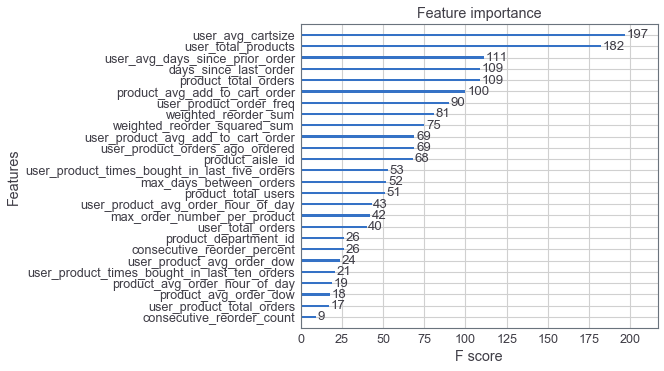

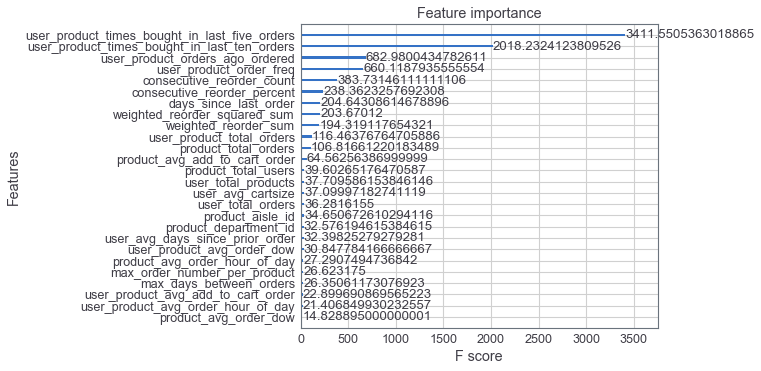

In [68]:
xgb.plot_importance(gbm);
    # Frequency, of all of the trees we trained, AveOccup was used 6526
xgb.plot_importance(gbm, importance_type='gain');
    # Information gain calculation (go back to tree notebook)